# Monophonic pitch extraction for query-by-humming
### George Tzanetakis, University of Victoria 

In this notebook we will look at how monophonic pitch detection can be 
used in a query-by-humming system. The approach used is a simplification 
of what is used in actual query-by-humming systems and is just for illustrative 
purposes. 

A query-by-humming system processes audio recordings of users singing 
a melody from a song that they are trying to find. The scenario is that 
they remember parts of a melody but not the title of the song. The system 
has to convert the audio query to some kind of representation that is then 
used to find the corresponding song in a data set of reference songs. 
Depending on the system the database can be MIDI tracks, audio tracks, or 
MIDI tracks with associated audio tracks. 

For this notebook we will not look into how the search and indexing 
of the reference database is performed and only consider how 
the query audio can be converted to a representation that can be used 
for searching. 

One common approach that we will follow in this notebook 
is to represent both queries and the associated melodies 
in the reference database as strings. The idea is that 
the resulting string of the query would be similar  
(most characters will be the same perhaps with a few 
substitutions and additions) to the correspond string 
representation of the melody in the reference database. 

We want our queries to work even if they are sung in a different 
key or with different timing and in this notebook we will 
focus on this aspect. 



In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 
import IPython.display as ipd

Let's load an audio recording

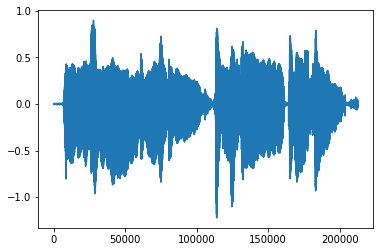

In [2]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("amazing_grace_female.wav")
# scale to -1.0/1.0 
audio_signal = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
audio_signal = (0.9 / max(audio_signal)) * audio_signal

plt.figure() 
plt.plot(audio_signal)
ipd.Audio(audio_signal,rate=srate)


Now that we have seen how we can estimate the pitch of a single frame of audio 
we can abstract this process into functions and then write a function that 
given an audio signal returns the associated pitch track and amplitude track (RMS) 
using a particular pitch extraction method. 

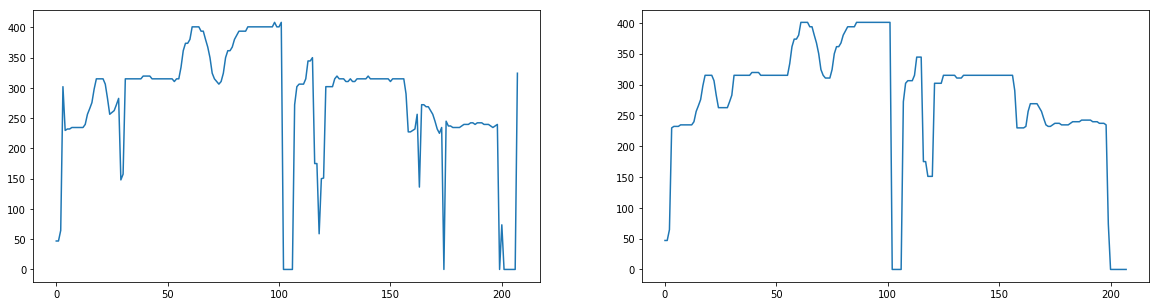

In [3]:

def pitch_zcrs(frame, srate): 
    indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]
    pitch_estimate = (srate / np.mean(np.diff(indices)))
    return pitch_estimate 

def pitch_fft(frame, srate): 
    mag = np.abs(np.fft.fft(frame))
    mag = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag) * (srate / len(frame))
    return pitch_estimate 
    
def pitch_acr(frame, srate): 
    acr = np.correlate(frame, frame, mode='full')
    acr = acr[int(len(acr)/2):]
    low_lag = np.argmin(acr)
    max_lag = np.argmax(acr[low_lag:])
    
    pitch_estimate = srate/float(low_lag + max_lag)
    return pitch_estimate

def pitch_track(signal, hopSize, winSize, extractor): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 500): 
            pitch_track[m] = 0 
        
        
    return (amp_track, pitch_track)

hopSize = 1024
winSize = 4096

# compute the pitch tracks 
(at, pt) = pitch_track(audio_signal, hopSize, winSize, pitch_acr)

# applying median filtering to smooth the pitch tracks 
pt1 = signal.medfilt(pt, kernel_size=5)

plt.figure(figsize=(20,5)) 
plt.subplot(121)
plt.plot(pt)
plt.subplot(122)
plt.plot(pt1)
plt.show()
    

We will be working with MIDI note numbers and cents rather than Hz. So let's convert the pitch track from Hz to midi. 
As you can see for this recording the singer is quite accurate and mostly stays close to the discrete pitch of an equal temperament chromatic scale (the integer MIDI note numbers)

[ 0.          0.          0.         57.74602585 57.92730856 57.92730856
 57.92730856 58.11050964 58.11050964 58.11050964 58.11050964 58.11050964
 58.11050964 58.48283239 59.65039881 60.26510269 60.90243872 62.25213547
 63.21417966 63.21417966]
[ 0.  0.  0. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 60. 60. 61. 62.
 63. 63.]


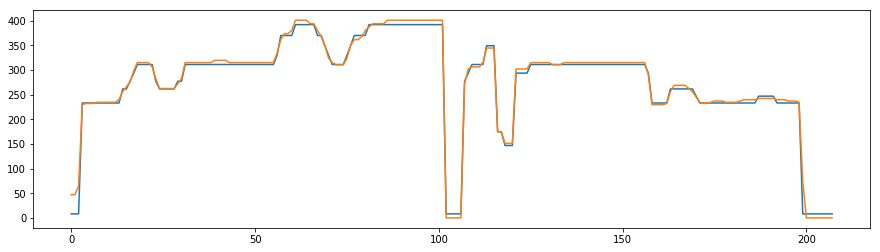

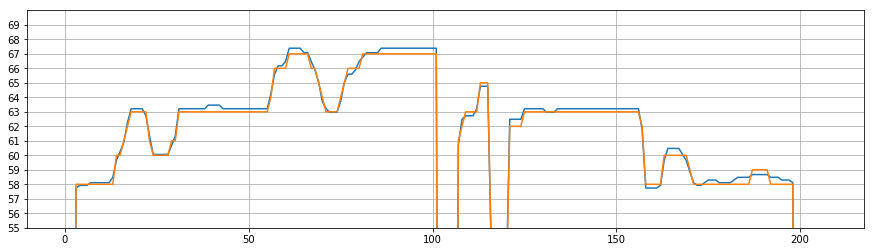

In [4]:
# replace zeros with 1 to avoid issues with log2 
pt4 = np.where(pt1==0, 1, pt1)
# convert to midi 
float_midi = 69 + 12*np.log2(pt4/440.)
# quantize midi 
int_midi = np.array([round(x) for x in float_midi])


for (i,f) in enumerate(float_midi): 
    if f < 40: 
        float_midi[i] = 0 
        int_midi[i] = 0 

print(float_midi[:20])
print(int_midi[:20])

# convert back to Hz
qpt = [440 * (2.0 ** ((x-69.0)/12.0)) for x in int_midi]

plt.figure(figsize=(15,4))
plt.plot(qpt)
plt.plot(pt1)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(float_midi)
plt.plot(int_midi)
plt.ylim(55, 70)
plt.grid(True)
plt.yticks(np.arange(55,70))
plt.show()



One possibility for representing a query as a string can be to convert the midi pitch track 
to a string representation. 

In [5]:
print(int_midi)

midi2letter = {} 
midi2letter[0] = "X" 
midi2letter[43] = "G"
midi2letter[44] = "g"
midi2letter[45] = "A"
midi2letter[46] = "a"
midi2letter[47] = "B"
midi2letter[48] = "b"
midi2letter[50] = "D"
midi2letter[51] = "d"
midi2letter[53] = "F"
midi2letter[54] = "f"
midi2letter[55] = "G"
midi2letter[56] = "g"
midi2letter[57] = "A"
midi2letter[58] = "a"
midi2letter[59] = "B" 
midi2letter[60]  = "C"
midi2letter[61] = "c" 
midi2letter[62] = "D"
midi2letter[63] = "d"
midi2letter[64] = "E"
midi2letter[65] = "F"
midi2letter[66] = "f"
midi2letter[67] = "G"
midi2letter[68] = "g" 
midi2letter[69] = "A"
midi2letter[70] = "a" 

# convert the MIDI track to a list of characters. I made 
# up the mapping but it does roughly correpond to note names 
# (A,B,C .. ) with lower letters denotes sharps. 

melody_string = [midi2letter[x] for x in int_midi]
melody_string = "".join(melody_string)
print(melody_string)


[ 0.  0.  0. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 60. 60. 61. 62.
 63. 63. 63. 63. 63. 61. 60. 60. 60. 60. 60. 61. 61. 63. 63. 63. 63. 63.
 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63.
 63. 63. 64. 66. 66. 66. 66. 67. 67. 67. 67. 67. 67. 66. 66. 65. 64. 63.
 63. 63. 63. 64. 65. 66. 66. 66. 66. 67. 67. 67. 67. 67. 67. 67. 67. 67.
 67. 67. 67. 67. 67. 67. 67. 67. 67. 67. 67. 67.  0.  0.  0.  0.  0. 61.
 62. 63. 63. 63. 63. 65. 65. 65. 53. 53. 50. 50. 50. 62. 62. 62. 62. 63.
 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63.
 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 63. 62. 58. 58. 58. 58.
 58. 60. 60. 60. 60. 60. 60. 60. 59. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58. 58. 59. 59. 59. 59. 59. 58. 58. 58. 58. 58. 58.
 58.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
XXXaaaaaaaaaaaCCcDdddddcCCCCCccdddddddddddddddddddddddddEffffGGGGGGffFEddddEFffffGGGGGGGGGGGGGGGGGGGGGXXXXXcDddddFFFFFDDDDDDDdddddddddddddddddddddddddddddd

We want our sting representation to be invariant to pitch shifting and time stretching. 
By that I mean that ideally the string representation of the same melody starting from 
a different note or being sung slower or faster should result in a similar string 
to the query. In addition the string representation should be unique in the sense 
that different melodies should map to different string representations. For example 
if we map every query to the same string then it would be a pitch and time invariant 
representation but would provide no discrimination. To check the pitch and time 
invariance let's create some example signals by using pitch and time shifting 
of the audio recording. A technique called phasevocoding is utilized to achieve 
independent pitch shifting and time stretching. We will describe a little bit 
more this technique when we talk about autotuning. 


In [6]:
import pyrb

shifted_down = pyrb.pitch_shift(audio_signal, srate, -4)
shifted_up = pyrb.pitch_shift(audio_signal, srate, 3) 
time_stretched = pyrb.time_stretch(audio_signal, srate, 0.75)

ipd.display(ipd.Audio(audio_signal, rate=srate))
ipd.display(ipd.Audio(shifted_down, rate=srate))
ipd.display(ipd.Audio(shifted_up, rate=srate))
ipd.display(ipd.Audio(time_stretched, rate=srate))


First lets consider the simple representation where we map the discrete MIDI pitches 
of the quantized melody to letters. As you can observe it is somewhat time invariant 
(the corresponding strings of the original and time stretched versions are similar) 
but definately not pitch shift invariant. 

In [105]:
def audio2string(audio_signal): 
    hopSize = 1024
    winSize = 4096

    # compute the pitch tracks 
    (at, pt) = pitch_track(audio_signal, hopSize, winSize, pitch_acr)

    # applying median filtering to smooth the pitch tracks 
    pt1 = signal.medfilt(pt, kernel_size=5)
    
    # replace zeros with 1 to avoid issues with log2 
    pt4 = np.where(pt1==0, 1, pt1)
    # convert to midi 
    float_midi = 69 + 12*np.log2(pt4/440.)
    # quantize midi 
    int_midi = np.array([round(x) for x in float_midi])


    for (i,f) in enumerate(float_midi): 
        if f < 40: 
            float_midi[i] = 0 
            int_midi[i] = 0 
    melody_string = [midi2letter[x] for x in int_midi]
    melody_string = "".join(melody_string)
    return melody_string 


print("Original:\n" + audio2string(audio_signal))
print("Time stretched:\n " + audio2string(time_stretched))
print("Shifted up:\n " + audio2string(shifted_up))
print("Shifted down\n: "  + audio2string(shifted_down))

    


Original:
XXXaaaaaaaaaaaCCcDdddddcCCCCCccdddddddddddddddddddddddddEffffGGGGGGffFEddddEFffffGGGGGGGGGGGGGGGGGGGGGXXXXXcDddddFFFFFDDDDDDDddddddddddddddddddddddddddddddddDaaaaaCCCCCCCBaaaaaaaaaaaaaaaaBBBBBaaaaaaaXXXXXXXXX
Time stretched:
 XXXXXaaaaaaaaaaaaaaBCCcDdddddddDCBBBCCCcDdddddddddddddddddddddddddddddddddddFfffffGGGGGGGGGffEdddddddEEEBBBfGGGGGGGGGGGGGGGGggggggggGGXXXXXXXXXXcccDdFdddFFFFFFGGGDDDDDDddddddddddddddddddddddddddddddddddddddddddDaaaaaBCccccCCCCbaaaaaXXXaaaaaaaaaaaaBBBaaaBBBBBaaaaaaaaaXXXXXXXXXXX
Shifted up:
 XXXcccccccccccDdEffffffEDDDDDffffffffffffffBBBfffffffffffGAAaaaaaaaAAgGffffGGgAAAaaaaaaaaaaaaaaaaaaaaaXXXXXfffffgfggggFFFFFffffffffffffffffffffffffffffffffffccCcccDdddddddCCcccccccccccccccccccccccccccXXXXXXXX
Shifted down
: XXffffffffffffGgABBBBBBaggggGBBBBBBBBBBBBBBBBBBBBBBBBBBBBcDDddddddddDcCCBBBCcDDDDdddddddddddddddddddddXXXXXXBBBBBccccCBaaaaaBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBafffffgAAAggggFFffffffffffffffGGGGGGGGffffffXXXXXXX


In order to achieve pitch shift invariance we need to consider an intervalic rather than an absolute pitch representation. We can use the numpy diff function that returns the successive differences between elements 
of the input list. These differences correspond to music intervals such as minor/major thirds, fifths etc. 
A very simple representation that was used in early QBH system is to simply encode the direction of the interval 
resulting in an alphabet with three characters U: up, S: same, D: down. Here we will use a slightly more 
rich representation with U used for intervals larger than a major 3rd and u for intervals smaller (similarly 
for D, d when descending). 

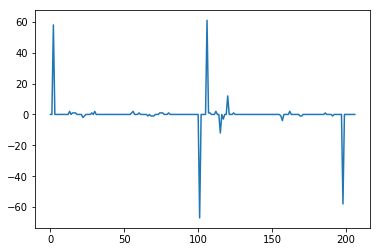

SSUSSSSSSSSSSuSuuuSSSSddSSSSuSuSSSSSSSSSSSSSSSSSSSSSSSSuuSSSuSSSSSdSdddSSSuuuSSSuSSSSSSSSSSSSSSSSSSSSDSSSSUuuSSSuSSDSdSSUSSSuSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSddSSSSuSSSSSSddSSSSSSSSSSSSSSSuSSSSdSSSSSSDSSSSSSSS


In [7]:
diff_midi = np.diff(int_midi)

plt.figure()
plt.plot(diff_midi) 
plt.show()

def interval2letter(i): 
    if i > 4: 
        return 'U'
    elif (i > 0): 
        return 'u'
    elif (i == 0): 
        return 'S'
    elif (i < -4): 
        return 'D'
    else: 
        return 'd'
        
    
diff_string = [interval2letter(d) for d in diff_midi]
diff_string = "".join(diff_string)
print(diff_string)
        


We can now look at the pitch shifted and time stretched signals. It is a bit hard to see but 
they are definitely more similar to each other than the absolute pitch string representation. 



In [107]:
def audio2stringI(audio_signal): 
    hopSize = 1024
    winSize = 4096

    # compute the pitch tracks 
    (at, pt) = pitch_track(audio_signal, hopSize, winSize, pitch_acr)

    # applying median filtering to smooth the pitch tracks 
    pt1 = signal.medfilt(pt, kernel_size=5)
    
    # replace zeros with 1 to avoid issues with log2 
    pt4 = np.where(pt1==0, 1, pt1)
    # convert to midi 
    float_midi = 69 + 12*np.log2(pt4/440.)
    # quantize midi 
    int_midi = np.array([round(x) for x in float_midi])

    diff_midi = np.diff(int_midi)
    
    def interval2letter(i): 
        if i > 0: 
            return 'U'
        elif (i == 0): 
            return 'S'
        else: 
            return 'D'
    
    diff_string = [interval2letter(d) for d in diff_midi]
    diff_string = "".join(diff_string)

    return diff_string 

print("Original:\n" + audio2stringI(audio_signal))
print("Time stretched:\n " + audio2stringI(time_stretched))
print("Shifted up:\n " + audio2stringI(shifted_up))
print("Shifted down\n: "  + audio2stringI(shifted_down))



Original:
SUUSSSSSSSSSSUSUUUSSSSDDSSSSUSUSSSSSSSSSSSSSSSSSSSSSSSSUUSSSUSSSSSDSDDDSSSUUUSSSUSSSSSSSSSSSSSSSSSSSSDSSSSUUUSSSUSSDSDSSUSSSUSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSDDSSSSUSSSSSSDDSSSSSSSSSSSSSSSUSSSSDSSSSSSDDSSSSSSS
Time stretched:
 UUSSUSSSSSSSSSSSSSUUSUUUSSSSSSDDDSSUSSUUUSSSSSSSSSSSSSSSSSSSSSSSSDSSSUSSSSSUUSSSSUSSSSSSSSDSDDSSSSSSUSSDSSUUSSSSSSSSSSSSSSSUSSSSSSSDSDSSSSSSSSSUSSUUDUSSUSSSSDDSSUUSSSSUSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSDDSSSSUUUSSSDSSSDDSSSSDSSUSSSSSSSSSSSUSSDSSUSSSSDSSSSSSSSDDDSSSSSSSS
Shifted up:
 USUSSSSSSSSSSUUUUSSSSSDDSSSSDSSSSSUSSSSSSDDSSUUSSSSSSSSSUUSUSSSSSSDSDDDSSSUSUUSSUSSSSSSSSSSSSSSSSSSSSDSSSSUSSSSUUUSSSDSSUSUSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSDSDUSSUUSSSDSSUSUSSSSSSSSSSSSSSSSSSSSSSSSSSDSSSSSSS
Shifted down
: SUSSSSSSSSSSSUUUUSSSSSDDSSSDDSSUSSSSSSSSSSSSSSSSSSSSSSSSUUSUSSSSSSSDDDSDSSUUUSSSUSSSSSSSSSSSSSSSSSSSSDSSSSSUSSSUUSSSDDDSSSSUSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSDDSSSSUUSSDDSSUSUSSSSSSSSSSSSSUSSSSSSSDSSSSSDDSSSSS


To conclude monophonic pitch detection is the first step in query-by-humming systems. A common approach is to convert both queries and references in the database to a common string-based representation. That way efficient search and indexing techniques developed for strings can be used for the matching process. In this notebook we look at a simple absolute MIDi pitch mapping and a better intervalic pitch representation that is to some extent pitch and time shift invariant. There are many additional issues that working QBH systems have to deal with. These includes on the query side the quantization of time into rhythmic units (quarter notes, eighth notes, etc), repetition, partial matching, non-linear time stretching, inaccuracies in the sung pitch. On the reference side issues to be dealt with include the extraction of the melody from symbolic representations such as MIDI, the indexing of the database, and the efficient calculation of approximate string similarity. 


